In [1]:
import sys
sys.path.append("../../lib")

In [314]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import lif_utils
import scipy.signal
import dlop_ldn_function_bases as bases

In [3]:
def wnd_hann(xs):
    return (0.5 - 0.5 * np.cos(2.0 * np.pi * xs)) * np.logical_and(xs >= 0.0, xs <= 1.0)

In [4]:
def wnd_rect(xs):
    return 1.0 * np.logical_and(xs >= 0.0, xs <= 1.0)

In [393]:
def scalar_data_to_multi_dim(xs, xmin=-1, xmax=1, N=100, overlap=2, wnd=wnd_hann):
    xs_rescaled = np.clip(((N - 1) / overlap) * (xs - xmin) / (xmax - xmin) + 0.5, 0.5, 0.5 * N)
    #print(xs_rescaled)
    res = wnd(xs_rescaled[..., None] - np.linspace(0, (N - 1) / overlap, N))
    return res / np.sum(res + 1e-9, axis=1)[..., None]

In [6]:
def mk_low_pass_filter_basis(q, N, Nmul=1, tau0=0.1, tau1=100.0):
    ts = np.linspace(0, Nmul, N * Nmul)
    taus = np.geomspace(tau0, tau1, q)
    res = np.array([np.exp(-ts / tau) for tau in taus])
    return res / np.sum(res, axis=1)[:, None]

In [449]:
dt, T = 1e-3, 10.0
ts = np.arange(0, T, dt)
N = len(ts)
A_tar = np.random.randn(N)
A_tar = nengo.Lowpass(200e-3).filt(A_tar, dt=dt)
A_tar = np.clip(A_tar - np.percentile(A_tar, 5), 0, None)
A_tar = np.clip(50 * A_tar / np.percentile(A_tar, 95), 0.1, None)
J_tar = lif_utils.lif_rate_inv(A_tar)

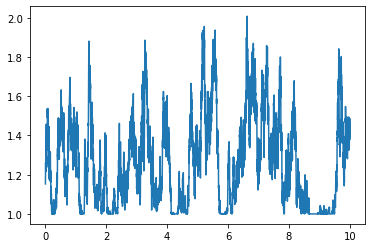

In [450]:
fig, ax = plt.subplots()
ax.plot(ts, J_tar)

In [451]:
def sim_neuron(Js, neuron_type, dt=1e-3):
    N = len(Js)
    T = N * dt
    with nengo.Network() as model:
        gain = 2.0
        ens = nengo.Ensemble(n_neurons=1, dimensions=1, gain=gain * np.ones(1), bias=np.zeros(1), neuron_type=neuron_type)
        nd = nengo.Node(lambda t: Js[int(t / dt) % N] / gain)
        nengo.Connection(nd, ens.neurons, transform=np.ones((1, 1)), synapse=None)
        p = nengo.Probe(ens.neurons, 'voltage', synapse=None)

    with nengo.Simulator(model) as sim:
        sim.run(T)

    return sim.trange(), sim.data[p]

In [452]:
ts, As = sim_neuron(J_tar, nengo.LIF())
ts, As_ref = sim_neuron(A_tar, nengo.SpikingRectifiedLinear())

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

(0.0, 1.0)

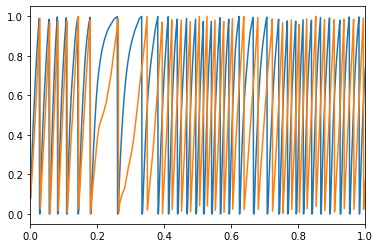

In [456]:
fig, ax = plt.subplots()
ax.plot(ts, As)
ax.plot(ts, As_ref)
ax.set_xlim(0, 1)

In [410]:
#As_flt = nengo.Lowpass(100e-3).filt(As)[:, 0]
#As_ref_flt = nengo.Lowpass(100e-3).filt(As_ref)[:, 0]

215.81767929435253


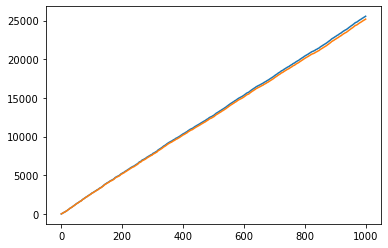

In [411]:
fig, ax = plt.subplots()
ax.plot(ts, As_flt)
ax.plot(ts, As_ref_flt)

print(np.sqrt(np.mean(np.square(As_ref_flt - As_flt))))
#ax.set_xlim(0, 50)

In [412]:
def filter_signal(us, A):
    res = np.zeros((len(us), A.shape[0]))
    for i in range(A.shape[0]):
        res[:, i] = scipy.signal.fftconvolve(us, A[i], 'full')[:len(us)]
    return res

In [434]:
H = mk_low_pass_filter_basis(1, 1000, 3, tau0=0.0002, tau1=1.0)

In [435]:
As_flt_conv = filter_signal(As_flt, H)
As_flt_conv.shape

(1000000, 1)

In [440]:
mask = scalar_data_to_multi_dim(A_tar, xmin=0.0, xmax=np.percentile(A_tar, 95), N=2)

In [441]:
As_flt_conv_masked = (As_flt_conv[:, :, None] * mask[:, None, :])
As_flt_conv_masked.shape

(1000000, 1, 2)

In [442]:
As_flt_conv_masked = As_flt_conv_masked.reshape(N, -1)

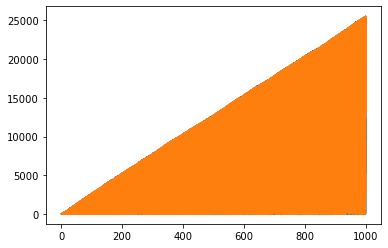

In [446]:
fig, ax = plt.subplots()
ax.plot(ts, As_flt_conv_masked);

In [427]:
D = np.linalg.lstsq(As_flt_conv_masked, As_ref_flt, rcond=1e-2)[0]

9.008112955121739


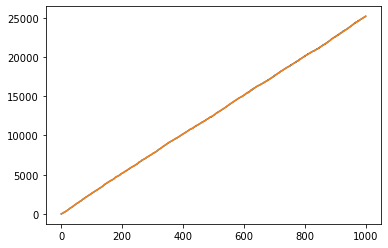

In [428]:
fig, ax = plt.subplots()
ax.plot(ts, As_flt_conv_masked @ D)
ax.plot(ts, As_ref_flt)
print(np.sqrt(np.mean(np.square(As_ref_flt - As_flt_conv_masked @ D))))
#ax.set_xlim(10, 20)

(0.0, 100.0)

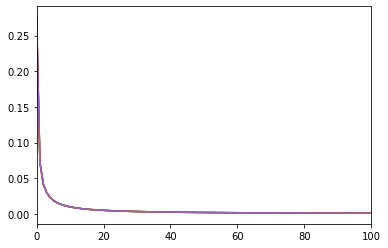

In [429]:
fig, ax = plt.subplots()
for i in range(5):
    ax.plot(H.T @ D.reshape(H.shape[0], mask.shape[1])[:, i])
    
ax.set_xlim(0, 100)